#### Topic Modeling
This script performs topic modelling for different number of topics using gensim library. Also for each topic model,
generated its visualization using pyLDAvis library. The visualization represents the topic-word distribution. From the 
visualizations, we can interpret the topics. 
The data needs to be cleaned before performing the modeling to remove unwanted tokens which do not represent any meaning and also are not helpful in distingushing topics. 
Lastly, we can also check the coherence score to find the #num of topics which best represent our corpus. The higher the coherence score, the better it is.

In [1]:
import numpy as np 
import pandas as pd
import spacy
import string
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim
import gensim.models.phrases as gen
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from gensim.models.coherencemodel import CoherenceModel

**Read the previously cleaned data**

In [2]:
all_emails_df = pd.read_csv('emails_spacy_refined.csv')

** Perform data cleaning **

Remove unwanted tokens

In [3]:
# Remove unwanted words
not_good = set(['fw','re','ees','com','ect','|','http','ena','go', 'isp',\
                'get','www','et','ena','as','don','id','ask','ct', 'monday',\
               'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',\
                'new', 'please', 'thanks', 'subject', 'hou', 'plz', 'fyi', 'day', 'hey'])
def clean_text(x):
    new_str = x.split()
    new_str = [word for word in new_str if word not in not_good]
    for i in range(len(new_str)-1):

        if new_str[i] == new_str[i+1]:
            new_str[i] = ''
    new_str = ' '.join(new_str)
    new_str = new_str.replace('  ', ' ')
    return new_str      

In [4]:
# Look at the word distribution
from nltk.stem import WordNetLemmatizer
all_emails_df.email = all_emails_df.email.apply(clean_text)
lemmatizer  = WordNetLemmatizer()
content_lemma = [' '.join([lemmatizer.lemmatize(word.strip(',;!?".')) for word in content.split()])\
                 for content in all_emails_df.email]
all_emails_df.email = content_lemma
finalList =[item for sublist in all_emails_df.email for item in sublist.split()]
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:10]

[('enron', 321132),
 ('time', 145861),
 ('power', 142216),
 ('company', 132247),
 ('energy', 131043),
 ('market', 114252),
 ('mail', 108948),
 ('gas', 102412),
 ('price', 97569),
 ('information', 97341)]

In [5]:
all_emails_df.email[:10]

0                                             forecast
1    business meeting fun trip presentation busines...
2                                  test successful way
3    randy schedule salary level scheduling group t...
4                                                     
5                                         greg phillip
6    distribution list update phillip allen mike gr...
7                                              morning
8            login static address sub gate dns company
9    phillip allen buckner buck collar floor gas pr...
Name: email, dtype: object

In [6]:
# Remove the words having count < 4, mostly they will be spelling mistakes or another language.
less_counts = set([k for k, v in c.items() if v<4])
finalList =[item for item in finalList if item not in less_counts]
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:10]

[('enron', 321132),
 ('time', 145861),
 ('power', 142216),
 ('company', 132247),
 ('energy', 131043),
 ('market', 114252),
 ('mail', 108948),
 ('gas', 102412),
 ('price', 97569),
 ('information', 97341)]

In [7]:
text_list = [text.split() for text in all_emails_df.email]
text_list = [[x for x in sub_list if (x not in less_counts)]\
             for sub_list in text_list]
text_list = [sublist for sublist in text_list if len(sublist) > 10]

In [8]:
len(text_list) #497537

314758

** Create Bigrams **

Bigrams provide the meaning to frequently occuring adjacent words.

In [9]:
phrases = gen.Phrases(text_list, min_count=10)
bigram = gen.Phraser(phrases)
bigram_text_list = bigram[text_list]

In [10]:
len(bigram_text_list)

314758

** Create doc-term matrix **

In [11]:
# Doc term matrix will be fed in the topic model
dictionary = corpora.Dictionary(bigram_text_list)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in bigram_text_list]

**Run LDA**

In [34]:
# Runs LDA model for different numbers of topics.
Lda = models.LdaMulticore
coherenceList_cv = []
num_topics_list = np.arange(3,30,2)
for num_topics in tqdm(num_topics_list):
    lda = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, workers=36,
             passes=2,chunksize=10000,random_state=4)
    cm_cv = CoherenceModel(model = lda, corpus = doc_term_matrix,
                           texts = bigram_text_list,\
                           dictionary = dictionary, coherence = 'c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis,'pyLDAvis_{}.html'.format(num_topics))

100%|██████████| 14/14 [2:20:17<00:00, 601.25s/it] 


In [13]:
Lda = models.LdaMulticore
lda = Lda(doc_term_matrix, num_topics=19, id2word = dictionary, workers=36,
         passes=2,chunksize=10000,random_state=4)
cm_cv = CoherenceModel(model = lda, corpus = doc_term_matrix,
                       texts = bigram_text_list,\
                       dictionary = dictionary, coherence = 'c_v')
vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
pyLDAvis.save_html(vis,'pyLDAvis.html')

** Visualize coherence score for topic selection**

Text(0,0.5,'Coherence Score')

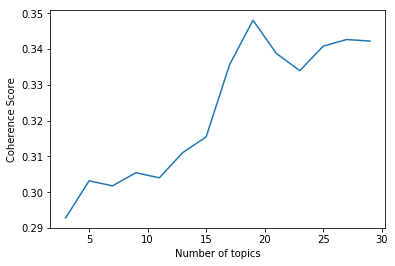

In [36]:
# Look a the coherence score(cv)
plt.plot(np.arange(3,30,2),coherenceList_cv) 
plt.xlabel('Number of topics')
plt.ylabel('Coherence Score')


Here we see 19 topics are the best among all.

In [14]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [15]:
get_lda_topics(lda, num_topics = 19)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19
0,enron,time,power,enron,enron,enron,enron,database_engine,time,enron,gas,enron,enron,enron,enron,enron,enron,enron,enron
1,company,power,service,information,energy,information,price,error_borland,market,power,company,company,time,year,time,time,meeting,market,mail
2,power,message,enron,week,mail,power,market,energy,mail,market,enron,deal,mail,time,year,year,time,power,company
3,energy,enron,company,time,power,time,gas,enron,power,service,power,market,meeting,state,corp,meeting,company,agreement,time
4,year,energy,energy,scheduled_outage,service,mail,time,price,week,contract,energy,energy,unknown_database,power,agreement,employee,energy,energy,gas
5,market,information,agreement,message,information,energy,information,company,energy,trading,state,time,week,business,company,question,power,company,energy
6,time,market,time,company,company,email,energy,email,price,business,price,mail,company,company,price,company,service,question,power
7,business,mail,information,service,market,california,state,information,enron,year,california,power,energy,california,document,business,scheduled_outage,north_america,year
8,information,price,insufficient_memory,comment,houston,state,year,question,california,agreement,year,information,database_alias,information,week,energy,market,today,week
9,corp,group,operation_alias,report,meeting,ferc,business,time,service,california,customer,service,question,energy,comment,houston,information,state,stock


### NMF

In [107]:
text_data = all_emails_df[['email']]

In [108]:
text_data = text_data.astype('str')

In [109]:
for idx in range(len(text_data)):
    text_data.iloc[idx]['email'] =\
    [word for word in text_data.iloc[idx]['email'].split(' ')\
     if ((word not in not_good) or (word not in less_counts))]

In [110]:
train = [value[0] for value in text_data.iloc[0:].values]
train = [ls for ls in train if len(ls) > 10]
train_data = [' '.join(text) for text in train]

In [111]:
vectorizer = CountVectorizer(analyzer='word', max_features=100000)
x_counts = vectorizer.fit_transform(train_data)

In [112]:
#set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)

In [113]:
#normalize the TfIdf values so each row has unit length.
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [114]:
#obtain a NMF model.
num_topics = 19
model = NMF(n_components=num_topics, init='nndsvd')
#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=19, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [74]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [115]:
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19
0,schedule,perlingiere,enron,kay,description,database,deal,sara,request,vince,delainey,jeff,report,agreement,mail,gas,meeting,carol,btu
1,final,debra,employee,mann,time,alias,kate,shackleton,resource,kaminski,david,dasovich,expense,master,email,power,time,clair,weekly
2,variance,smith,america,corp,chairperson,unknown,symes,smith,approval,shirley,regard,kean,status,draft,message,price,week,phone,latest
3,hour,america,north,ben,calendar,closed,evelyn,street,srrs,crenshaw,guy,richard,name,comment,information,market,tomorrow,mark,mail
4,preferred,texas,company,jacoby,entry,error,prebon,houston,auth,stinson,john,steven,employee,copy,address,contract,conference,fax,issue
5,hourahead,north,corp,suzanne,detailed,operation,kerri,texas,name,interview,janet,shapiro,amount,letter,confidential,energy,today,tana,power
6,ancillary,street,sally,enron,migration,borland,broker,fax,type,presentation,dave,steffes,concur,change,web,volume,office,taylor,phone
7,detail,fax,beck,fred,central,hourahead,peak,north,application,john,rob,james,due,document,sender,daily,morning,jones,fax
8,log,houston,mark,kathleen,outlook,engine,mike,america,date,resume,milnthorp,corp,total,form,your,california,good,cell,report
9,file,phone,stock,sheila,appointment,insufficient,sharen,phone,approver,gibner,mark,paul,link,isda,error,company,room,suzanne,kaminski
